# Linear Bidding Strategy

In [1]:
# Import Lib
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math
import random
from sklearn.utils import resample
from sklearn.externals import joblib
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score
import xgboost

from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### IMPORT DATA

In [2]:
#import Pickled Data

X_train = pickle.load(open("X_train_features.pkl", 'rb'))
y_train = pickle.load(open("y_train_features.pkl", 'rb'))
X_validation = pickle.load(open("X_validation_features.pkl", 'rb'))
y_validation = pickle.load(open("y_validation_features.pkl", 'rb'))
X_test = pickle.load(open("X_test_features.pkl", 'rb'))



X_train_pay = pickle.load(open("X_train_pay.pkl", 'rb'))

Lin_features = pickle.load(open('bestFeatures.pkl', 'rb'))


In [3]:
#import unprocessed original data

traindf = pd.read_csv("train.csv")
validationdf = pd.read_csv("validation.csv")
testdf = pd.read_csv("test.csv")


traindf.head()

,click,weekday,hour,bidid,userid,useragent,IP,region,city,adexchange,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,5,22,b7bea80521fdecd95d2d761a38c91c3f09618066,2e880fb7d690cf7377b2e42e701728e3f3c0e4c1,windows_ie,125.37.175.*,2,2,2.0,...,200,2,0,5,a4f763f78ef3eedfe614263b94a8924e,238,5,0f951a030abdaedd733ee8d114ce2944,3427,NaN
1,0,1,20,4f51205475678f5a124bc76b2c54163bf8eaa7eb,3a1fe01360ff8100e7d006b83b77a3e4c01d928c,windows_chrome,171.36.92.*,238,239,1.0,...,250,FourthView,Na,0,10722,294,23,NaN,2821,NaN
2,0,3,13,b604e3fd054a658ab7ced4285ebf2ef54d2bd890,801d18a056b6fe6b06a794aef17fb0d6daff2414,windows_ie,59.46.106.*,40,41,2.0,...,250,2,0,5,798b2d49952d77f1eace9f23c210d0b5,238,24,0f951a030abdaedd733ee8d114ce2944,3427,"10052,10006,13866,10110"
3,0,6,23,0348beeae93e561584c3b50fc9e7746a33048ad7,0d6eaf2259699990e38a1fc5116f112070b9ecdc,windows_ie,114.250.226.*,1,1,1.0,...,600,2,1,0,cb7c76e7784031272e37af8e7e9b062c,300,25,bebefa5efe83beee17a3d245e7c5085b,1458,"13866,10063,10111"
4,0,5,6,268149c1789bce2bc9798ffd97ec431219bafeb3,a239d9bb642460d974ba67f85e63b8d3e214da0e,windows_ie,183.63.192.*,216,233,2.0,...,90,OtherView,Na,133,7330,277,133,NaN,2259,NaN


In [4]:
#Liimit the input data by the feature columns

feature_X_train = X_train[Lin_features].values
feature_X_val = X_validation[Lin_features].values
feature_X_test = X_test[Lin_features].values

#print(len(X_validation.columns))

In [5]:
'''
Creating the necessary variables for the the average CTR 
and the range which will be used to test the base bid
'''
avgCTR = traindf["click"].sum()*100/traindf.shape[0]
bid_list = list(range(traindf.loc[traindf["click"] == 1, "payprice"].min(),300, 5))


avgBid_training = traindf.loc[traindf["click"] == 1, "payprice"].mean()
print("In the training data, the average CTR is: %.4f , and the average BID is: $%.2f"
      % (avgCTR, avgBid_training))


In the training data, the average CTR is: 0.0738 , and the average BID is: $105.46


In [6]:
def output_AUROC (x_p, classifier, clr):
    
    fpr, tpr, thresholds = roc_curve(y_validation, x_p)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color=clr, lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for ' + classifier)
    plt.legend(loc="lower right")
    plt.show()


### LOG REG

Accuracy: 0.995209
RMSE: 0.069215
ROC_AUC: 0.616668


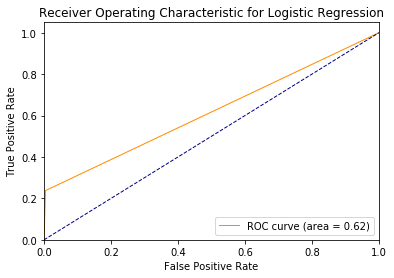

In [19]:
'''
Use logistic regression to model the training data for clicks.
Get the probablility of each row getting a click for both the validation and test dataset
'''

logreg_clf = LogisticRegression(C = 0.1, random_state = 123)
logreg_clf.fit(feature_X_train, y_train)

l_x_predict = logreg_clf.predict(feature_X_val)


predict_proba_list_val = logreg_clf.predict_proba(feature_X_val)

predict_proba_list_test = logreg_clf.predict_proba(feature_X_test)


validationdf['click_proba_log'] = [item[1] for item in predict_proba_list_val]
testdf['click_proba_log'] = [item[1] for item in predict_proba_list_test]

accuracy=accuracy_score(y_validation,l_x_predict)
print("Accuracy: %f" % (accuracy))

rmse = np.sqrt(mean_squared_error(y_validation, l_x_predict))
print("RMSE: %f" % (rmse))

roc_auc=roc_auc_score(y_validation,l_x_predict)
print("ROC_AUC: %f" % (roc_auc))

output_AUROC (l_x_predict, "Logistic Regression", 'darkorange')


### XGB

Accuracy: 0.994423
RMSE: 0.074680
ROC_AUC: 0.697904


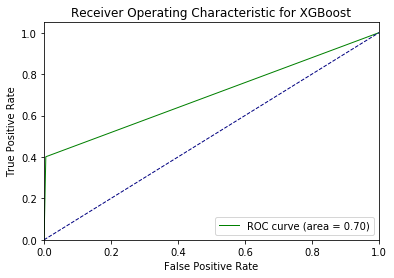

In [8]:

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', colsample_bytree = 0.2, learning_rate = 0.1,
               max_depth = 5, alpha = 10, n_estimators = 500, random_state = 123)


xgb_clf.fit(feature_X_train, y_train)

x_predict = xgb_clf.predict(feature_X_val)

predict_proba_list_val = xgb_clf.predict_proba(feature_X_val)

predict_proba_list_test = xgb_clf.predict_proba(feature_X_test)

validationdf['click_proba_xgb'] = [item[1] for item in predict_proba_list_val]
testdf['click_proba_xgb'] = [item[1] for item in predict_proba_list_test]


accuracy=accuracy_score(y_validation,x_predict)
print("Accuracy: %f" % (accuracy))

rmse = np.sqrt(mean_squared_error(y_validation, x_predict))
print("RMSE: %f" % (rmse))

roc_auc=roc_auc_score(y_validation,x_predict)
print("ROC_AUC: %f" % (roc_auc))

output_AUROC (x_predict, "XGBoost", 'green')

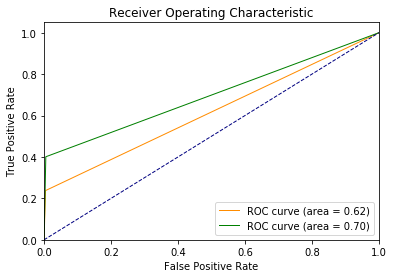

In [21]:
# l_x_predict
# x_predict

fpr1, tpr1, thresholds1 = roc_curve(y_validation, l_x_predict)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, thresholds2 = roc_curve(y_validation, x_predict)
roc_auc2 = auc(fpr2, tpr2)

plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='green', lw=1, label='ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### PREDICT THE VALIDATION DATAFRAME

In [9]:
'''
Linear bidding which bids on each row based on the mulipication of the base bid 
by the row's likeliness of getting a click, divided by the avg CTR'''


def lin_bid(base_bid, df, click_col, budget = 6250000):
    
    bid = (base_bid * df[click_col]) / avgCTR
        
    counter = 0
    clicks = 0
    imp = 0
    spent = 0
    
    while ((budget >= 0) & (counter < len(df))):

        if(df['payprice'][counter] < bid[counter]):
            budget -= df['payprice'][counter]
            spent += df["payprice"][counter]
            clicks += df['click'][counter]
            imp += 1
            
        counter += 1
        
    ctr = clicks/imp
    cpm = spent/imp
    cpc = spent/clicks/1000
    spent = round(spent/6250000 *100)
    
    
    return clicks, ctr, spent, cpm, cpc, imp, bid

In [10]:
def run_lin_bid_model(df, click_col):
    clicks_list = []
    imp_list = []

    for bid in bid_list:

        clicks, ctr, spent, cpm, cpc, imp, bids = lin_bid(bid, df, click_col)
        print("Bidding $ %s scores:: %s clicks, %.5f ctr, %s spent, %.2f cpm, %.2f cpc, %s imp"  
              % (bid, clicks, ctr, spent, cpm, cpc, imp))
        clicks_list.append(clicks)
        imp_list.append(imp)  

    plt.figure(figsize = (10,8))

    plt.subplot(3,1,1)
    plt.plot(bid_list, imp_list, "b-" )
    plt.xlabel("Base Bid")
    plt.ylabel("# of Impressions")
    plt.show()

    plt.figure(figsize = (10,8))

    plt.subplot(3,1,1)
    plt.plot(bid_list, clicks_list, "r")

    plt.xlabel("Base Bid")
    plt.ylabel("# of Clicks")
    plt.show()
    
    return clicks_list, imp_list

Bidding $ 4 scores:: 7 clicks, 0.00241 ctr, 0.0 spent, 8.00 cpm, 3.31 cpc, 2900 imp
Bidding $ 9 scores:: 39 clicks, 0.00405 ctr, 2.0 spent, 14.08 cpm, 3.48 cpc, 9623 imp
Bidding $ 14 scores:: 60 clicks, 0.00344 ctr, 5.0 spent, 18.27 cpm, 5.31 cpc, 17448 imp
Bidding $ 19 scores:: 73 clicks, 0.00283 ctr, 9.0 spent, 22.09 cpm, 7.82 cpc, 25837 imp
Bidding $ 24 scores:: 82 clicks, 0.00234 ctr, 14.0 spent, 25.26 cpm, 10.80 cpc, 35053 imp
Bidding $ 29 scores:: 96 clicks, 0.00215 ctr, 20.0 spent, 27.78 cpm, 12.92 cpc, 44628 imp
Bidding $ 34 scores:: 103 clicks, 0.00192 ctr, 26.0 spent, 29.97 cpm, 15.65 cpc, 53776 imp
Bidding $ 39 scores:: 115 clicks, 0.00183 ctr, 32.0 spent, 31.92 cpm, 17.44 cpc, 62835 imp
Bidding $ 44 scores:: 119 clicks, 0.00166 ctr, 39.0 spent, 33.90 cpm, 20.38 cpc, 71527 imp
Bidding $ 49 scores:: 122 clicks, 0.00152 ctr, 46.0 spent, 35.84 cpm, 23.53 cpc, 80092 imp
Bidding $ 54 scores:: 128 clicks, 0.00145 ctr, 53.0 spent, 37.53 cpm, 25.90 cpc, 88352 imp
Bidding $ 59 scores

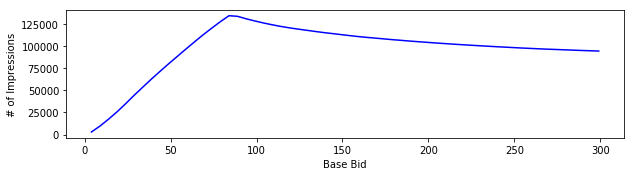

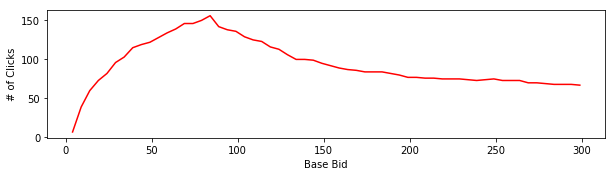

In [11]:
clicks_list_logreg, imp_list_logreg = run_lin_bid_model(validationdf, 'click_proba_log')

Bidding $ 4 scores:: 19 clicks, 0.00721 ctr, 0.0 spent, 7.92 cpm, 1.10 cpc, 2635 imp
Bidding $ 9 scores:: 58 clicks, 0.00765 ctr, 2.0 spent, 14.31 cpm, 1.87 cpc, 7585 imp
Bidding $ 14 scores:: 75 clicks, 0.00556 ctr, 4.0 spent, 19.14 cpm, 3.44 cpc, 13489 imp
Bidding $ 19 scores:: 86 clicks, 0.00438 ctr, 7.0 spent, 22.99 cpm, 5.25 cpc, 19634 imp
Bidding $ 24 scores:: 100 clicks, 0.00384 ctr, 11.0 spent, 26.14 cpm, 6.80 cpc, 26035 imp
Bidding $ 29 scores:: 107 clicks, 0.00330 ctr, 15.0 spent, 28.49 cpm, 8.63 cpc, 32400 imp
Bidding $ 34 scores:: 113 clicks, 0.00289 ctr, 19.0 spent, 30.47 cpm, 10.54 cpc, 39097 imp
Bidding $ 39 scores:: 121 clicks, 0.00264 ctr, 24.0 spent, 32.07 cpm, 12.15 cpc, 45841 imp
Bidding $ 44 scores:: 128 clicks, 0.00244 ctr, 28.0 spent, 33.69 cpm, 13.83 cpc, 52565 imp
Bidding $ 49 scores:: 132 clicks, 0.00223 ctr, 33.0 spent, 35.18 cpm, 15.78 cpc, 59229 imp
Bidding $ 54 scores:: 136 clicks, 0.00207 ctr, 38.0 spent, 36.56 cpm, 17.66 cpc, 65678 imp
Bidding $ 59 score

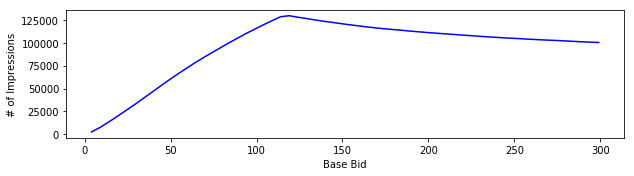

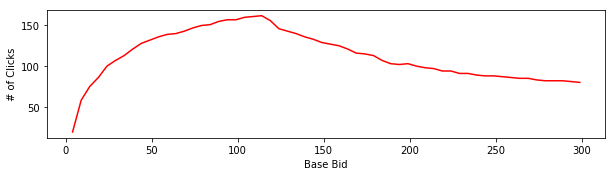

In [12]:
clicks_list_xgb, imp_list_xgb = run_lin_bid_model(validationdf, 'click_proba_xgb')

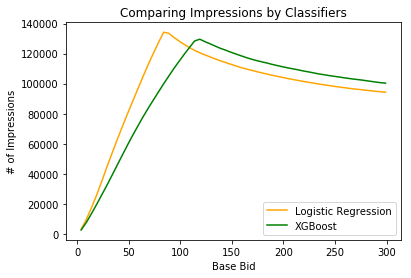

In [24]:
# Compare the # of Impressions from both classifiers together

plt.plot(bid_list, imp_list_logreg, 'orange', label='Logistic Regression') # logreg in orange 
plt.plot(bid_list, imp_list_xgb, 'g', label='XGBoost') # logreg in orange 
plt.xlabel("Base Bid")
plt.ylabel("# of Impressions")
plt.title('Comparing Impressions by Classifiers')
plt.legend(loc="lower right")
plt.show()

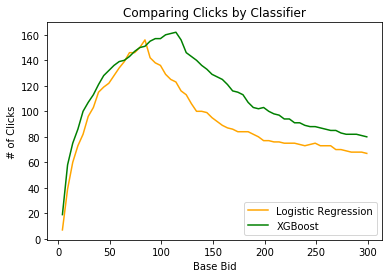

In [23]:
# Compare the # of Clicks from both classifiers together

plt.plot(bid_list, clicks_list_logreg, 'orange', label='Logistic Regression') # logreg in orange 
plt.plot(bid_list, clicks_list_xgb, 'g', label='XGBoost') # xgb in green
plt.xlabel("Base Bid")
plt.ylabel("# of Clicks")
plt.title('Comparing Clicks by Classifier')
plt.legend(loc="lower right")
plt.show()

### BEST RESULTS

In [15]:
#Best results for Logistic Regression

l_bid = 85

clicks, ctr, spent, cpm, cpc, imp, bids = lin_bid(l_bid, validationdf, "click_proba_log")
print("THE BEST BID IS")
print("Bidding $ %s scores:: %s clicks, %.5f ctr, %s spent, %.2f cpm, %.2f cpc, %s imp"  
      % (l_bid, clicks, ctr, spent, cpm, cpc, imp))

THE BEST BID IS
Bidding $ 85 scores:: 157 clicks, 0.00116 ctr, 100.0 spent, 46.04 cpm, 39.76 cpc, 135587 imp


In [16]:
#Best results for XGBoost

xgb_bid = 115

clicks, ctr, spent, cpm, cpc, imp, bids = lin_bid(xgb_bid, validationdf, "click_proba_xgb")
print("THE BEST BID IS")
print("Bidding $ %s scores:: %s clicks, %.5f ctr, %s spent, %.2f cpm, %.2f cpc, %s imp"  
      % (xgb_bid, clicks, ctr, spent, cpm, cpc, imp))


THE BEST BID IS
Bidding $ 115 scores:: 162 clicks, 0.00125 ctr, 99.0 spent, 47.73 cpm, 38.10 cpc, 129322 imp


### LEADERBOARD BIDS

In [17]:
#Will output the csv which will be used for the leaderboard website
l_bid = 115
testdf['bidprice'] = round((l_bid * testdf["click_proba_xgb"]) / avgCTR)


leaderboard_output = testdf[['bidid','bidprice']]

#DETERMINE HOW TO SORT
#leaderboard_output = leaderboard_output.sort_values(by='bidprice', ascending=False)
leaderboard_output.to_csv("testing bidding price.csv", index=False)

leaderboard_output.head(10)

,bidid,bidprice
0,366c563de7d90feb9d4dab53e795a93fb3157387,284.0
1,29167d4caa719788b5a342dbaa25151d53121f80,335.0
2,ff8bc3f4d44a3ea60c5f3a3a8fbe7cd98fb2966e,36.0
3,844c2da00d45315f20b748ec131c26ee99a7cbc7,32.0
4,c6017f0ad0c44d7d0c9b62583ea863f28941c0ca,83.0
5,7493c42f6d8f29d9f414b75c125ce3db40461ef9,104.0
6,819fb6958ea48b10430710d009c57d55a31debcb,22.0
7,8660774f6c94e32dfbd46add8a9bc94df3c74130,76.0
8,ccc4c75ae4fd33526e5ecdae482c45c1dabc94db,39.0
9,d9a212303746d85553966e902a315ba8812dd138,93.0
